<a href="https://colab.research.google.com/github/mushthofa-am/Identity-Mapping-ResNet-Lasagne/blob/master/cnn_effective_grid_size_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Effective Grid Size Reduction


#### Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Libraries

In [2]:
import os
import time
import pickle
import statistics
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import keras
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import TensorBoard, Callback
from keras.layers import Input, Conv2D, MaxPool2D, Activation, Dropout, Dense, \
                        GlobalAveragePooling2D, Flatten, BatchNormalization, \
                        concatenate

Using TensorFlow backend.


### Set

In [0]:
data_path = "drive/My Drive/Colab Notebooks/dataset/80-20/80-20-24.pkl"
save_path = "drive/My Drive/Colab Notebooks"

img_size = 24

### Load Data

In [4]:
p_in = open(data_path, "rb")
loaded_data = pickle.load(p_in)
p_in.close()

X_train, y_train, X_test, y_test, num_classes, label_classes = loaded_data

train_info = "train : {} images  and {} labels".format(len(X_train), len(y_train))
test_info = "\ntest : {} images and {} labels".format(len(X_test), len(y_test))
num_class_info = "\nnumber of classes : {}".format(num_classes)
label_info = "\nlabel {}".format(label_classes)

print(train_info, test_info, num_class_info, label_info)

train : 14400 images  and 14400 labels 
test : 3600 images and 3600 labels 
number of classes : 36 
label ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


### Train and Test samples

train label 18, shape (24, 24)
test label 16, shape (24, 24)


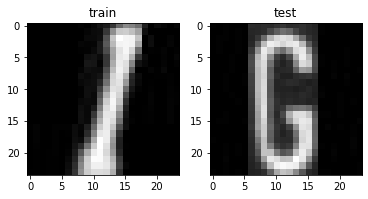

In [5]:
index = 3
print('train label {}, shape {}'.format(y_train[index], X_train[index].shape))
print('test label {}, shape {}'.format(y_test[index], X_test[index].shape))

plt.subplot(121), plt.imshow(X_train[index], 'gray'), plt.title('train')
plt.subplot(122), plt.imshow(X_test[index], 'gray'), plt.title('test')
plt.show()

### Preprocessing

In [6]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
input_shape = X_train[0].shape

X_train = (X_train.astype('float32'))/255
X_test = (X_test.astype('float32'))/255

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

shape_img_info = "train shape : {}, test shape : {}".format(X_train.shape, X_test.shape)
shape_label_info = "\ntrain label shape : {}, test label shape {}".format(y_train.shape, y_test.shape)
input_shape_info = "\ninput shape : {}".format(input_shape)

print(shape_img_info, shape_label_info, input_shape_info)

train shape : (14400, 24, 24, 1), test shape : (3600, 24, 24, 1) 
train label shape : (14400, 36), test label shape (3600, 36) 
input shape : (24, 24, 1)


## Auxiliary

In [0]:
class TimeHistory(Callback):
    def on_train_begin(self, logs = {}):
        self.times = []
    def on_epoch_begin(self, batch, logs = {}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, batch, logs = {}):
        self.times.append(time.time() - self.epoch_time_start)

def creating_path_save(name):
    save = os.path.join(save_path, name)
    if not os.path.exists(save):
        os.mkdir(save)

    paths = ['logs', 'models', 'histories', 'recordings']

    path_group = []
    for _path in paths:
        preset_path = os.path.join(save, _path)
        if not os.path.exists(preset_path):
            os.mkdir(preset_path)
            print(f'{preset_path} created')
        path_group.append(preset_path)

    return path_group

def saving_results(model, histories, recordings, name,
                   path_models, path_histories, path_recordings):
    model.save(os.path.join(path_models, "m-{}.h5".format(name)))

    p_out = open(os.path.join(path_histories, "h-{}.pkl".format(name)), "wb")
    pickle.dump(histories, p_out)
    p_out.close()

    p_out = open(os.path.join(path_recordings, "r-{}.pkl".format(name)), "wb")
    pickle.dump(recordings, p_out)
    p_out.close()

    print(f'\n{name} saved\n')

### Module

In [0]:
def conv(X, filter_numbers, filter_size, strides, paddings):
    X = Conv2D(filter_numbers, (filter_size, filter_size), strides=strides, padding=paddings)(X)
    
    return X

def conv_bn(X, filter_numbers, filter_size, strides, paddings):
    X = Conv2D(filter_numbers, (filter_size, filter_size), strides=strides, padding=paddings)(X)
    X = BatchNormalization()(X)
    
    return X

def conv_act(X, filter_numbers, filter_size, strides, paddings):
    X = Conv2D(filter_numbers, (filter_size, filter_size), strides=strides, padding=paddings)(X)
    X = Activation('relu')(X)
    
    return X

def max_pool(X, filter_size, strides, paddings):
    X = MaxPool2D((filter_size, filter_size), strides=strides, padding=paddings)(X)

    return X

def incept_conv_max(X, filter_numbers, filter_size, strides, paddings):
    X_conv = conv_act(X, filter_numbers, filter_size, strides, paddings)
    X_pool = max_pool(X, filter_size, strides, paddings)

    concat = concatenate([X_conv, X_pool], axis=3)

    return concat

### Model






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "effective-downsampling-177-0-1585213395"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 24, 24, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22,

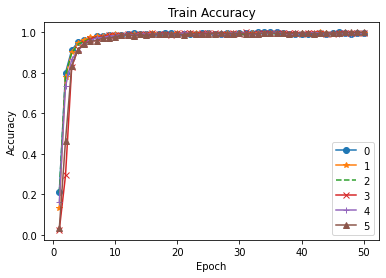

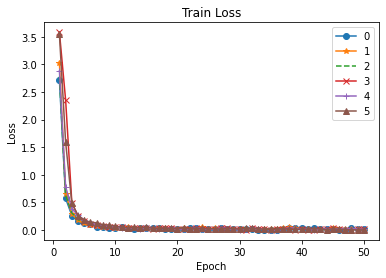

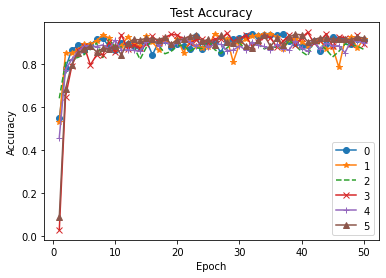

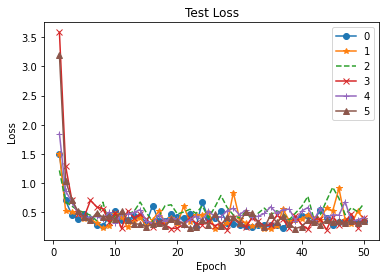

In [9]:
class ConvolutionalNetworks:
    def __init__(self):
        self.results = []
        self.histories_group = []

    def architecture(self):
        filter_numbers = (32, 64, 128, 256)

        name = "effective-downsampling"
        code_name = "177"

        epochs = 50
        batchs = 128
        optimizers = 'adam'
        attempts = 6

        X_input = Input(shape=input_shape)
        path_logs, path_models, path_histories, path_recordings = creating_path_save(name)

        for attempt in range(attempts):
            save_name = f"{name}-{code_name}-{attempt}-{int(time.time())}"
        
            X = conv_act(X_input, filter_numbers[0], 3, 1, 'same')
            X = conv_act(X, filter_numbers[1], 3, 1, 'same')
            X = max_pool(X, 3, 1, 'valid')

            X = conv_act(X, filter_numbers[1], 3, 1, 'same')
            X = max_pool(X, 3, 2, 'valid')

            X = conv_act(X, filter_numbers[2], 3, 1, 'same')
            X = conv_act(X, filter_numbers[2], 3, 1, 'same')
            X = max_pool(X, 3, 2, 'valid')
            
            X = conv_act(X, filter_numbers[3], 3, 1, 'same')
            X = conv_act(X, filter_numbers[3], 3, 1, 'same')
            X = max_pool(X, 3, 1, 'valid')

            X = GlobalAveragePooling2D()(X)

            X = Dense(1024, name='fc')(X)
            X = Activation('relu', name='fc_relu')(X)
            X = Dropout(0.5, name='dropout')(X)

            X = Dense(num_classes, activation='softmax', name='softmax')(X)

            model = Model(inputs = X_input,
                          outputs = X,
                          name = save_name)
            
            model.summary()
            
            model.compile(
                loss = 'categorical_crossentropy',
                optimizer = optimizers,
                metrics=['accuracy'])

            time_callback = TimeHistory()
            tensorboard = TensorBoard(log_dir=os.path.join(path_logs, "{}".format(save_name)))

            histories = model.fit(
                X_train, y_train,
                validation_data = (X_test, y_test),
                epochs = epochs,
                batch_size = batchs,
                verbose = 1,
                callbacks = [time_callback, tensorboard])

            recordings = time_callback.times

            test_score = model.evaluate(X_test, y_test)
            acc_score = np.round(test_score[1]*100, 2)
            loss_score = np.round(test_score[0], 4)

            time_consumed = np.round(sum(recordings), 3) # Detik
            in_minutes = np.round(time_consumed/60, 3)
            recorded_mean = np.round(statistics.mean(recordings), 3)

            show_score = f'Test accuracy {acc_score}, test loss {loss_score}'
            show_total = f'\nTotal consumed : {time_consumed} seconds'
            show_minutes = f'\nTotal consumed in minutes : {in_minutes} minutes'
            show_speed = f'\nTime : {recorded_mean} second/epoch'

            print(show_score, show_total, show_minutes, show_speed)

            saving_results(model, histories, recordings, save_name,
                           path_models, path_histories, path_recordings)

            self.results.append([acc_score, loss_score, recorded_mean])
            self.histories_group.append(histories)

    def reporting_results(self):
        print('Recapitulation :')
        print('Accuracy')
        keep_acc = []
        for report in self.results:
            keep_acc.append(report[0])
            print(report[0])
        
        print()
        print('Loss')
        for report1 in self.results:
            print(report1[1])
        
        print()
        print('train_speed')
        for report2 in self.results:
            print(report2[2])

        print()
        mean_acc = np.round(np.mean(keep_acc), 2)
        print(f'Average accuracies : {mean_acc} %')
        
    def showing_graph(self):
        if keras.__version__=='2.3.1':
            format_hist = ['accuracy', 'val_accuracy']
        else:
            format_hist = ['acc', 'val_acc']

        form_group = ['o-', '*-', '--', 'x-', '+-', '^-']

        f, ax = plt.subplots() # Train Accuracy
        i = 0
        numbers = []
        for hist in self.histories_group:
            ax.plot([None] + hist.history['acc'], form_group[i])
            numbers.append(str(i))
            i += 1
        ax.legend(numbers, loc = 0) # loc = 0 => lokasi legend
        ax.set_title('Train Accuracy')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy')

        f, ax = plt.subplots() # Train Loss
        i = 0
        numbers = []
        for hist in self.histories_group:
            ax.plot([None] + hist.history['loss'], form_group[i])
            numbers.append(str(i))
            i += 1
        ax.legend(numbers, loc = 0) # loc = 0 => lokasi legend
        ax.set_title('Train Loss')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')

        f, ax = plt.subplots() # Test Accuracy
        i = 0
        numbers = []
        for hist in self.histories_group:
            ax.plot([None] + hist.history['val_acc'], form_group[i])
            numbers.append(str(i))
            i += 1
        ax.legend(numbers, loc = 0) # loc = 0 => lokasi legend
        ax.set_title('Test Accuracy')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy')

        f, ax = plt.subplots() # Test Loss
        i = 0
        numbers = []
        for hist in self.histories_group:
            ax.plot([None] + hist.history['val_loss'], form_group[i])
            numbers.append(str(i))
            i += 1
        ax.legend(numbers, loc = 0) # loc = 0 => lokasi legend
        ax.set_title('Test Loss')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')

if __name__=='__main__':
    cnn = ConvolutionalNetworks()
    cnn.architecture()
    cnn.reporting_results()
    cnn.showing_graph()

## Reference
Ignatius Wendianto Notonogoro, Jondri, Anditya Arifianto, "Indonesian License Plate Recognition Using Convolutional Neural Network", IEEE, Int. Conf. IColCT, 2018.